In [38]:
import pandas as pd

# Load the data from the CSV file
btc_data = pd.read_csv('Bitcoin Historical Data.csv')

# Ensure the data is sorted by date if not already
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data = btc_data.sort_values(by='Date')

# Calculate the 4-day and 7-day moving averages
btc_data['4MA'] = btc_data['Price'].rolling(window=4).mean()
btc_data['7MA'] = btc_data['Price'].rolling(window=7).mean()

# Display the updated DataFrame
btc_data.head(10)

,Date,Price,Open,High,Low,Vol. ('000),Change %,4MA,7MA
4111,2014-01-01,815.9,805.9,829.9,771.0,10.76,1.24%,NaN,NaN
4110,2014-01-02,856.9,815.9,886.2,810.5,12.81,5.02%,NaN,NaN
4109,2014-01-03,884.3,856.9,888.2,839.4,9.71,3.19%,NaN,NaN
4108,2014-01-04,924.7,884.3,932.2,848.3,14.24,4.57%,870.450,NaN
4107,2014-01-05,1014.7,924.7,1029.9,911.4,21.37,9.74%,920.150,NaN
4106,2014-01-06,1012.7,1014.7,1093.4,964.7,23.08,-0.21%,959.100,NaN
4105,2014-01-07,879.9,1012.7,1044.0,879.8,22.67,-13.11%,958.000,912.728571
4104,2014-01-08,938.8,879.9,966.9,858.9,14.1,6.70%,961.525,930.285714
4103,2014-01-09,937.0,938.8,964.6,866.5,14.42,-0.20%,942.100,941.728571
4102,2014-01-10,957.8,937.0,964.8,905.9,6.35,2.22%,928.375,952.228571


In [39]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Define a quadratic function for curve fitting
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

# Function to check for an upside trend before the cup

def has_upside_trend(prices, idx, lookback=3, min_increase=0.50):
    if idx < lookback:
        return False  # Not enough data for the lookback period
    recent_prices = prices[idx - lookback:idx]
    avg_increase = (recent_prices[-1] - recent_prices[0]) / recent_prices[0]
    return avg_increase >= min_increase


In [40]:

# Function to check for a valid cup formation with enhanced mathematical validation
def is_valid_cup(prices, tolerance=0.01, min_drop=0.05, max_edge_diff=0.02, min_curvature=0.0001, symmetry_tolerance=0.1):
    x = np.arange(len(prices))  # X-axis values (time indices)
    left_edge = prices[0]  # Left edge of the cup
    right_edge = prices[-1]  # Right edge of the cup
    bottom = prices.min()  # Bottom of the cup
    bottom_idx = np.argmin(prices)  # Index of the bottom

    # Ensure the bottom is at least `min_drop` lower than both edges
    if bottom >= left_edge * (1 - min_drop) or bottom >= right_edge * (1 - min_drop):
        return False

    # Ensure the left and right edges are within `tolerance` of each other
    if abs(left_edge - right_edge) / left_edge > tolerance:
        return False

    # Ensure the absolute difference between left and right edges is within `max_edge_diff`
    if abs(left_edge - right_edge) > max_edge_diff * left_edge:
        return False

    # Fit a quadratic curve to the prices
    try:
        params, _ = curve_fit(quadratic, x, prices)
        a, b, c = params

        # Check if the curve is a U-shape (a > 0)
        if a <= 0:
            return False

        # Check if the curvature is steep enough
        if a < min_curvature:
            return False

        # Check if the minimum point of the quadratic curve aligns with the bottom
        min_idx = -b / (2 * a)
        if abs(min_idx - bottom_idx) > len(prices) * 0.05:  # Allow a 5% deviation
            return False

        # Check for symmetry: Compare the left and right halves of the cup
        left_half = prices[:bottom_idx]
        right_half = prices[bottom_idx + 1:]
        if len(left_half) != len(right_half):  # Ensure equal lengths for comparison
            return False
        symmetry_diff = np.mean(np.abs(left_half[::-1] - right_half) / left_half[::-1])
        if symmetry_diff > symmetry_tolerance:
            return False

        # Check depth-to-width ratio
        cup_width = len(prices)
        cup_depth = max(left_edge, right_edge) - bottom
        if cup_depth / cup_width < 0.1:  # Ensure the depth is at least 10% of the width
            return False

    except Exception as e:
        print(f"Curve fitting failed: {e}")
        return False

    # Fit a quadratic curve to the prices
    try:
        params, _ = curve_fit(quadratic, x, prices)
        a, b, c = params

        # Check if the curve is a U-shape (a > 0)
        if a <= 0:
            return False

        # Check if the minimum point of the quadratic curve aligns with the bottom
        min_idx = -b / (2 * a)
        if abs(min_idx - bottom_idx) > len(prices) * 0.05:  # Allow a 5% deviation
            return False
    except:
        return False

    return True


In [41]:

# Function to check for a valid handle formation
# Function to check for a valid handle formation with enhanced validation
def is_valid_handle(prices, cup_bottom, cup_height, min_days=7, min_drop_ratio=0.30, max_slope=-0.001):
    handle_start = prices[0]
    handle_end = prices[-1]
    handle_drop = handle_start - handle_end
    required_drop = min_drop_ratio * (cup_height - cup_bottom)

    # Ensure the handle lasts at least `min_days` and drops by the required amount
    if len(prices) < min_days or handle_drop < required_drop:
        return False

    # Ensure the handle is a clear downward trend
    if not all(prices[i] >= prices[i + 1] for i in range(len(prices) - 1)):
        return False

    # Calculate the slope of the handle
    x = np.arange(len(prices))
    slope, intercept = np.polyfit(x, prices, 1)  # Fit a linear trend line

    # Ensure the slope is negative and steep enough
    if slope >= 0 or slope > max_slope:
        return False

    return True


In [42]:

# Function to check for a breakthrough after the handle
def has_breakthrough(prices, handle_end_idx):
    if handle_end_idx + 1 >= len(prices):
        return False  # Not enough data for breakthrough check
    handle_prices = prices[:handle_end_idx + 1]
    handle_slope = (handle_prices[-1] - handle_prices[0]) / len(handle_prices)

    # Check if the price breaks above the downward slope of the handle
    for i in range(handle_end_idx + 1, len(prices)):
        if prices[i] > handle_prices[-1] + handle_slope * (i - handle_end_idx):
            return True
    return False

btc_data["7MA"] = btc_data["Price"].rolling(window=7).mean()

# Detect cup and handle patterns in the price data
btc_data["Cup_Formation"] = 0
btc_data["Handle_Formation"] = 0
btc_data["Breakthrough"] = 0
btc_data["Cup_Start"] = np.nan
btc_data["Cup_End"] = np.nan
prices = btc_data["4MA"].values

for idx in range(len(btc_data) - 60):  # Ensure enough data for a 30-day window
    for period in range(14, 60):  # Check for periods between 14 and 60 days
        if idx + period < len(btc_data):
            cup_prices = prices[idx:idx + period]
            if has_upside_trend(prices, idx, lookback=5, min_increase=0.05) and is_valid_cup(cup_prices, tolerance=0.1, min_drop=0.10):
                cup_bottom = min(cup_prices)
                cup_height = max(cup_prices[0], cup_prices[-1])
                btc_data.loc[idx + period - 1, "Cup_Formation"] = 1  # Mark the rightmost position of the cup
                btc_data.loc[idx + 7, "Cup_Start"] = 1  # Mark the starting point of the cup
                btc_data.loc[idx + period - 1, "Cup_End"] = 1  # Mark the ending point of the cup

                # Check for handle formation
                handle_start_idx = idx + period
                for handle_period in range(7, 15):  # Check for handle periods between 7 and 15 days
                    if handle_start_idx + handle_period < len(btc_data):
                        handle_prices = prices[handle_start_idx:handle_start_idx + handle_period]
                        if is_valid_handle(handle_prices, cup_bottom, cup_height, min_days=7, min_drop_ratio=0.30):
                            btc_data.loc[handle_start_idx + handle_period - 1, "Handle_Formation"] = 1

                            # Check and mark for breakthrough
                            if has_breakthrough(prices, handle_start_idx + handle_period - 1):
                                btc_data.loc[handle_start_idx + handle_period - 1, "Breakthrough"] = 1
                            break


In [43]:
# number of cup start and end points detected
cup_start_points = btc_data["Cup_Start"].sum()
cup_end_points = btc_data["Cup_End"].sum()
print(f"Number of cup start points detected: {cup_start_points}")
print(f"Number of cup end points detected: {cup_end_points}")

# number of patterns detected
patterns_detected = btc_data["Cup_Formation"].sum()
print(f"Number of cup and handle patterns detected: {patterns_detected}")

# number of breakthroughs detected
breakthroughs_detected = btc_data["Breakthrough"].sum()
print(f"Number of breakthroughs detected: {breakthroughs_detected}")

Number of cup start points detected: 7.0
Number of cup end points detected: 7.0
Number of cup and handle patterns detected: 7
Number of breakthroughs detected: 0


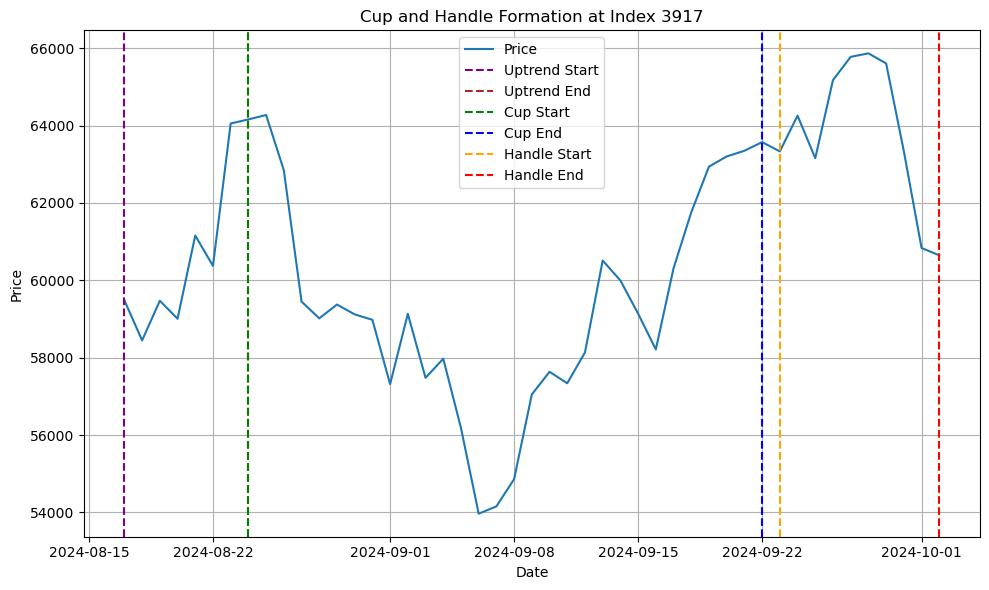

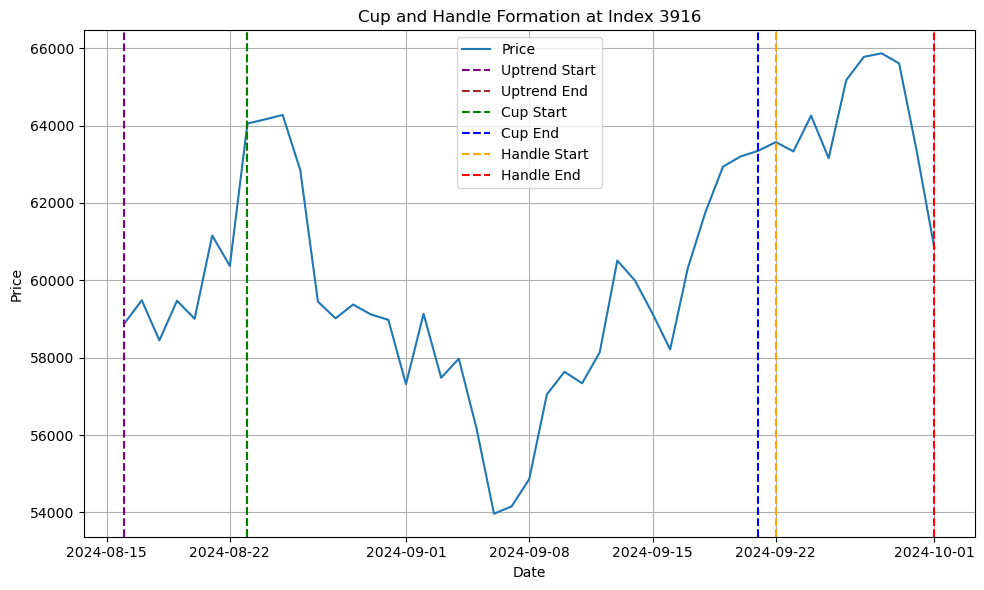

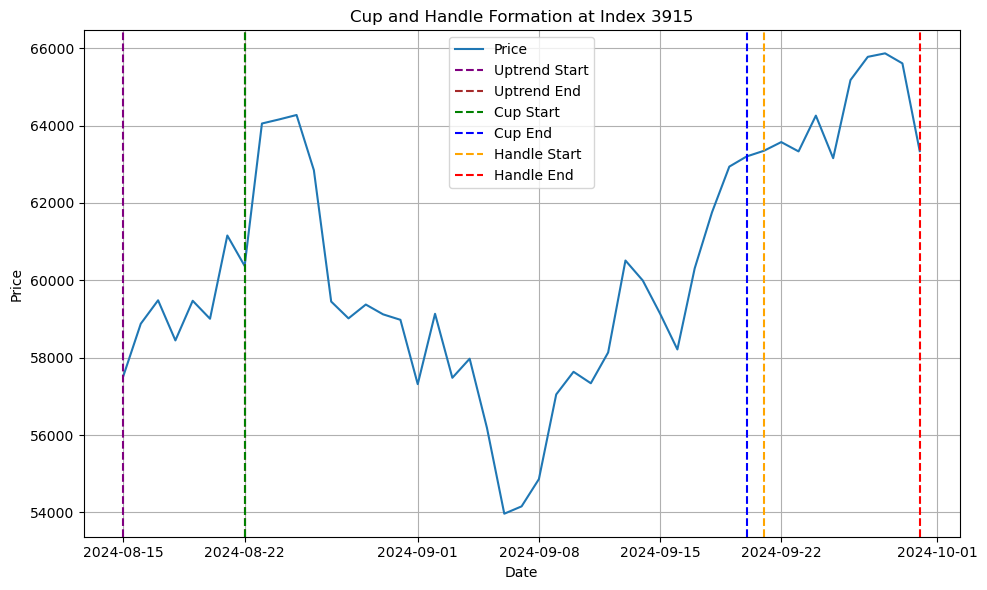

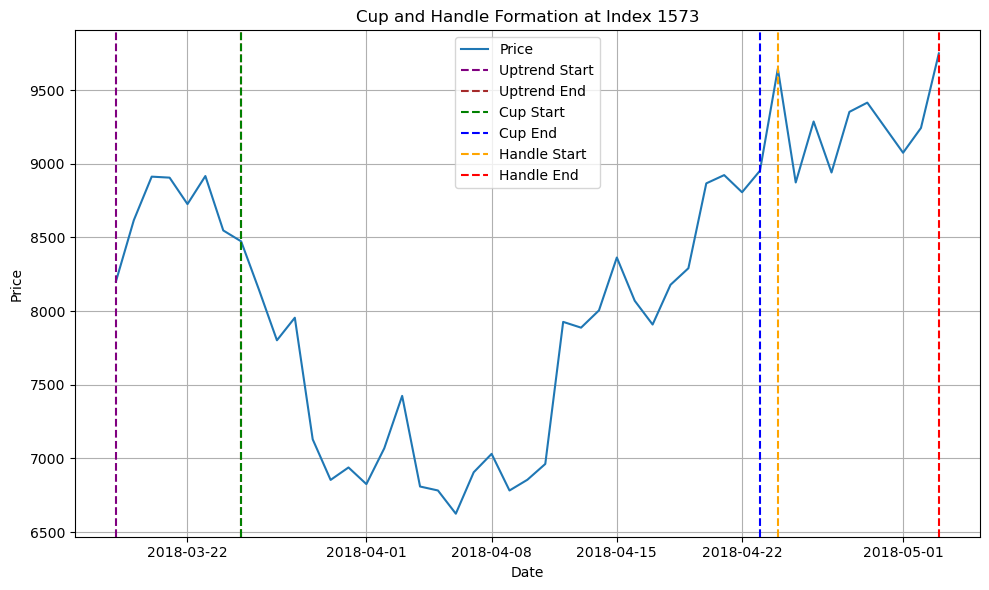

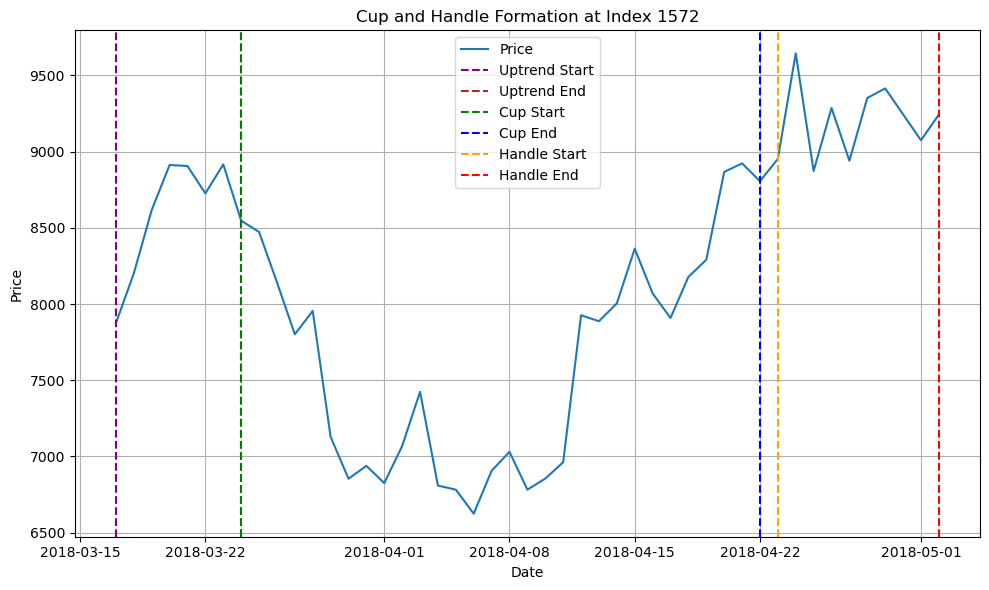

In [44]:
# Plot the first 5 cup and handle formations
import matplotlib.pyplot as plt

# Filter the rows where a cup formation is detected
cup_indices = btc_data[btc_data["Cup_Formation"] == 1].index[:5]

# Define period and handle_period for plotting
period = 30  # Example value, adjust as needed
handle_period = 10  # Example value, adjust as needed
lookback = 7  # Lookback period for uptrend detection

# Plot the first 5 cup and handle formations
for idx in cup_indices:
    start_idx = idx - period + 1  # Start of the cup
    end_idx = idx  # End of the cup
    handle_start_idx = idx + 1  # Start of the handle
    handle_end_idx = handle_start_idx + handle_period - 1  # End of the handle
    uptrend_start_idx = start_idx - lookback  # Start of the uptrend
    uptrend_end_idx = start_idx  # End of the uptrend (start of the cup)

    # Validate indices
    if uptrend_start_idx < 0 or handle_end_idx >= len(btc_data):
        continue

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(
        btc_data["Date"].iloc[uptrend_start_idx:handle_end_idx + 1],
        btc_data["Price"].iloc[uptrend_start_idx:handle_end_idx + 1],
        label="Price"
    )
    plt.axvline(btc_data["Date"].iloc[uptrend_start_idx], color="purple", linestyle="--", label="Uptrend Start")
    plt.axvline(btc_data["Date"].iloc[uptrend_end_idx], color="brown", linestyle="--", label="Uptrend End")
    plt.axvline(btc_data["Date"].iloc[start_idx], color="green", linestyle="--", label="Cup Start")
    plt.axvline(btc_data["Date"].iloc[end_idx], color="blue", linestyle="--", label="Cup End")
    plt.axvline(btc_data["Date"].iloc[handle_start_idx], color="orange", linestyle="--", label="Handle Start")
    plt.axvline(btc_data["Date"].iloc[handle_end_idx], color="red", linestyle="--", label="Handle End")
    plt.title(f"Cup and Handle Formation at Index {idx}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [213]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema

def extract_cup_handle_patterns(
    df,
    price_col='Price',
    peak_order=5,
    cup_window=30,
    depth_thresh=0.20,
    sym_tol=0.10,
    handle_window=10,
    handle_depth=0.10
):
    """
    Scans df for cup & handle patterns and returns a DataFrame
    listing for each pattern:
      - Cup_Start_Date, Cup_Start_Price
      - Cup_Formation_Date, Cup_Formation_Price
      - Handle_Start_Date, Handle_Start_Price
      - Handle_Formation_Date, Handle_Formation_Price
      - Breakout_Date, Breakout_Price
    """
    df = df.sort_values('Date').reset_index(drop=True)
    prices = df[price_col].values

    # find local peaks/troughs
    max_idx = argrelextrema(prices, np.greater_equal, order=peak_order)[0]
    min_idx = argrelextrema(prices, np.less_equal,    order=peak_order)[0]

    patterns = []

    for trough in min_idx:
        # identify the shoulders
        left_peaks  = max_idx[max_idx < trough]
        right_peaks = max_idx[max_idx > trough]
        if len(left_peaks)==0 or len(right_peaks)==0:
            continue
        left  = left_peaks[-1]
        right = right_peaks[0]

        # enforce cup width
        if trough - left > cup_window or right - trough > cup_window:
            continue

        p_left    = prices[left]
        p_trough  = prices[trough]
        p_right   = prices[right]

        # depth & symmetry
        if (p_left - p_trough)/p_left < depth_thresh:
            continue
        if abs((p_left-p_trough)-(p_right-p_trough))/p_left > sym_tol:
            continue

        # now look for the handle
        handle_start = right + 1
        if handle_start >= len(prices):
            continue
        segment = prices[handle_start : min(handle_start + handle_window, len(prices))]
        if len(segment)==0:
            continue

        rel_min = np.argmin(segment)
        handle_trough = handle_start + rel_min
        p_handle_min  = prices[handle_trough]

        if (p_right - p_handle_min)/p_right > handle_depth:
            continue

        # and finally the breakout
        post_handle = prices[handle_trough:]
        crosses = np.where(post_handle > p_right)[0]
        if len(crosses)==0:
            continue
        breakout = handle_trough + crosses[0]

        # record the full pattern
        patterns.append({
            'Cup_Start_Date':        df.loc[left,   'Date'],
            'Cup_Start_Price':       df.loc[left,   price_col],
            'Cup_Formation_Date':    df.loc[right,  'Date'],
            'Cup_Formation_Price':   df.loc[right,  price_col],
            'Handle_Start_Date':     df.loc[handle_start, 'Date'],
            'Handle_Start_Price':    df.loc[handle_start, price_col],
            'Handle_Formation_Date': df.loc[handle_trough,  'Date'],
            'Handle_Formation_Price':df.loc[handle_trough,  price_col],
            'Breakout_Date':         df.loc[breakout, 'Date'],
            'Breakout_Price':        df.loc[breakout, price_col],
        })

    return pd.DataFrame(patterns)


# -------------------------
# Example usage:

btc = pd.read_csv('Bitcoin Historical Data.csv', parse_dates=['Date'])
patterns_df = extract_cup_handle_patterns(btc)

patterns_df = patterns_df = patterns_df.drop(patterns_df.index[2])

patterns_df

,Cup_Start_Date,Cup_Start_Price,Cup_Formation_Date,Cup_Formation_Price,Handle_Start_Date,Handle_Start_Price,Handle_Formation_Date,Handle_Formation_Price,Breakout_Date,Breakout_Price
0,2016-06-16,761.2,2016-07-02,698.1,2016-07-03,661.6,2016-07-07,635.3,2016-10-29,715.0
1,2017-03-15,1253.4,2017-04-11,1220.7,2017-04-12,1212.5,2017-04-13,1176.2,2017-04-20,1238.1
3,2021-04-13,63540.9,2021-05-01,57807.1,2021-05-02,56603.8,2021-05-04,53741.5,2021-05-08,58840.1
4,2022-01-12,43901.0,2022-02-09,44388.9,2022-02-10,43521.0,2022-02-18,40000.1,2022-03-01,44420.3
5,2024-07-28,68256.3,2024-08-08,61699.7,2024-08-09,60850.6,2024-08-15,57534.6,2024-08-23,64053.1


In [214]:
import matplotlib.pyplot as plt

def plot_cup_handle_patterns(btc_df, patterns_df):
    """
    For each row in patterns_df, extract btc_df between Cup_Start_Date and Breakout_Date
    and plot the price series, highlighting the key pattern points.
    """
    # make sure Date is datetime and sorted
    btc_df = btc_df.sort_values('Date').reset_index(drop=True)
    
    for idx, row in patterns_df.iterrows():
        start = row['Cup_Start_Date']
        end   = row['Breakout_Date']
        
        # extract the period
        mask   = (btc_df['Date'] >= start) & (btc_df['Date'] <= end)
        period = btc_df.loc[mask]
        
        # plot
        plt.figure(figsize=(10, 4))
        plt.plot(period['Date'], period['Price'], label='Price')
        
        # highlight the five key points
        pts_dates  = [
            row['Cup_Start_Date'],
            row['Cup_Formation_Date'],
            row['Handle_Start_Date'],
            row['Handle_Formation_Date'],
            row['Breakout_Date']
        ]
        pts_prices = [
            row['Cup_Start_Price'],
            row['Cup_Formation_Price'],
            row['Handle_Start_Price'],
            row['Handle_Formation_Price'],
            row['Breakout_Price']
        ]
        plt.scatter(pts_dates, pts_prices, color='red', zorder=5)
        
        # annotate each point
        labels = ['Cup Start','Cup Form','Handle Start','Handle Form','Breakout']
        for d, p, lab in zip(pts_dates, pts_prices, labels):
            plt.text(d, p, f' {lab}', va='bottom', fontsize=8)
        
        plt.title(f"Cup-&-Handle Pattern #{idx+1}\n{start.date()} → {end.date()}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.tight_layout()
        plt.show()


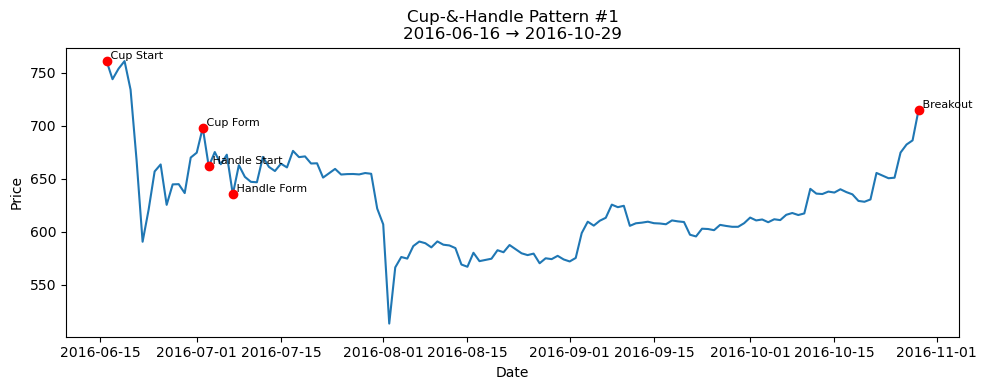

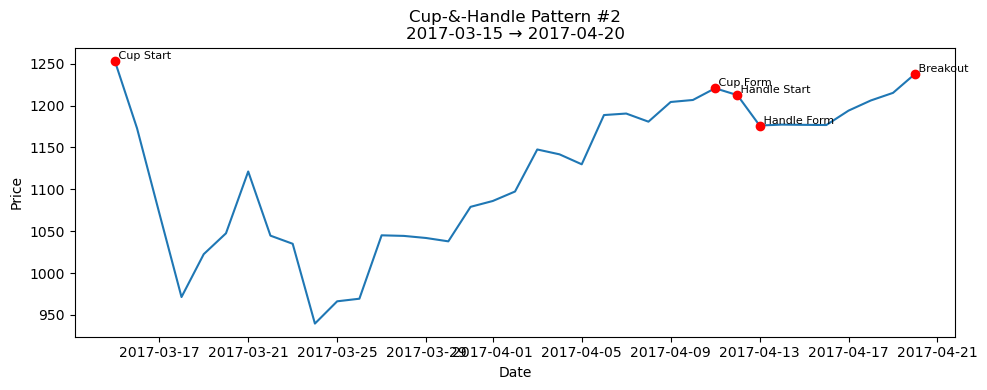

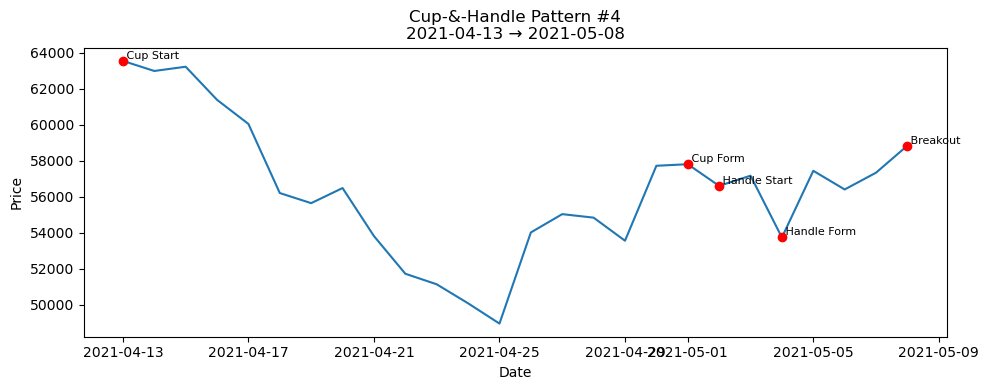

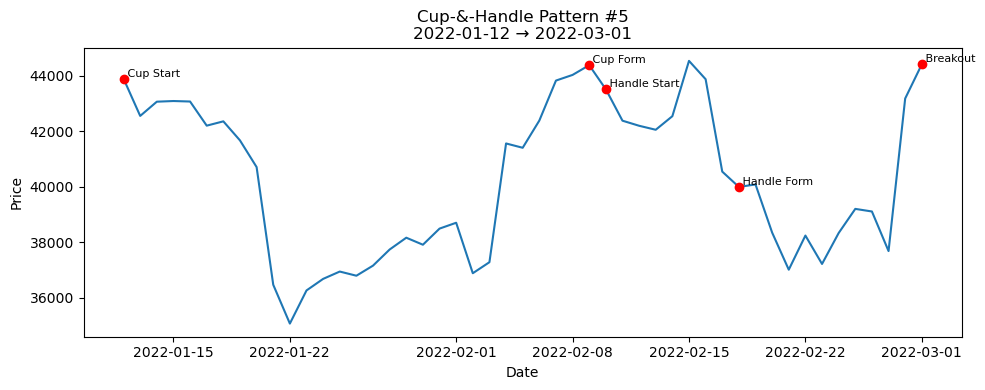

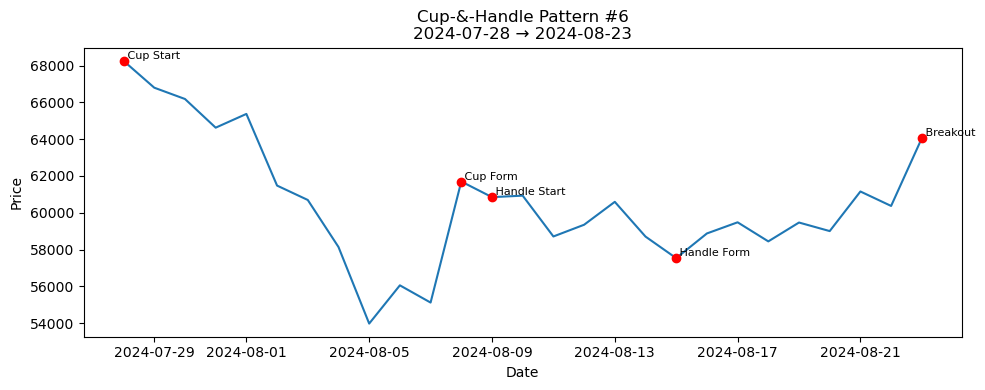

In [79]:
plot_cup_handle_patterns(btc_data, patterns_df)

In [215]:
import pandas as pd
import numpy as np

def add_cup_handle_features(patterns_df, btc_df,
                            price_col='Price',
                            vol_col="Vol. ('000)"):
    # --- prepare price & volume series
    btc = btc_df.copy()
    btc['Date'] = pd.to_datetime(btc['Date'])
    # parse volume (thousands) → float
    def parse_volume(vol):
        if 'M' in vol:
            return float(vol.replace('M', '').replace(',', '')) * 1_000
        elif 'B' in vol:
            return float(vol.replace('B', '').replace(',', '')) * 1_000_000
        else:
            return float(vol.replace(',', ''))

    btc['Volume'] = btc[vol_col].apply(parse_volume)
    
    # --- ensure datetime in patterns_df
    df = patterns_df.copy()
    for date_col in [
        'Cup_Start_Date',
        'Cup_Formation_Date',
        'Handle_Start_Date',
        'Handle_Formation_Date',
        'Breakout_Date'
    ]:
        df[date_col] = pd.to_datetime(df[date_col])
    
    # --- prepare lists to collect new features
    cup_depth       = []
    handle_depth    = []
    cup_duration    = []
    handle_duration = []
    left_slope      = []
    right_slope     = []
    volume_ratio    = []
    neckline_level  = []
    
    # --- compute row by row
    for _, row in df.iterrows():
        # key timestamps & prices
        csd = row['Cup_Start_Date']
        ced = row['Cup_Formation_Date']
        hsd = row['Handle_Start_Date']
        hed = row['Handle_Formation_Date']
        bkd = row['Breakout_Date']
        
        high1   = row['Cup_Start_Price']
        low_tr  = btc.loc[
                     (btc['Date'] >= csd) & (btc['Date'] <= ced),
                     price_col
                 ].min()
        handle_low = row['Handle_Formation_Price']
        breakout_level = row['Breakout_Price']
        
        # durations in days
        cd = (ced - csd).days
        hd = (hed - hsd).days
        
        # slopes (avoid div-by-zero)
        ls = (high1 - low_tr)/cd if cd>0 else np.nan
        rs = (breakout_level - low_tr)/cd if cd>0 else np.nan
        
        # average volumes
        vol_cup    = btc.loc[
                         (btc['Date'] >= csd) & (btc['Date'] <= ced),
                         'Volume'
                     ].mean()
        vol_handle = btc.loc[
                         (btc['Date'] >= hsd) & (btc['Date'] <= hed),
                         'Volume'
                     ].mean()
        vr = vol_handle/vol_cup if vol_cup>0 else np.nan
        
        # collect
        cup_depth.append      ((high1 - low_tr) / high1)
        handle_depth.append   ((breakout_level - handle_low) / breakout_level)
        cup_duration.append   (cd)
        handle_duration.append(hd)
        left_slope.append     (ls)
        right_slope.append    (rs)
        volume_ratio.append   (vr)
        neckline_level.append (row['Cup_Formation_Price'])
    
    # --- assign new columns
    df['Cup_Depth']       = cup_depth
    df['Handle_Depth']    = handle_depth
    df['Cup_Duration']    = cup_duration
    df['Handle_Duration'] = handle_duration
    df['Left_Slope']      = left_slope
    df['Right_Slope']     = right_slope
    df['Volume_Ratio']    = volume_ratio
    df['Neckline_Level']  = neckline_level
    
    return df

# ---- example usage ----
btc    = pd.read_csv('Bitcoin Historical Data.csv', parse_dates=['Date'])
# assume you already ran:
# patterns_df = extract_cup_handle_patterns(btc)

patterns_with_feats = add_cup_handle_features(patterns_df, btc)
patterns_with_feats

,Cup_Start_Date,Cup_Start_Price,Cup_Formation_Date,Cup_Formation_Price,Handle_Start_Date,Handle_Start_Price,Handle_Formation_Date,Handle_Formation_Price,Breakout_Date,Breakout_Price,Cup_Depth,Handle_Depth,Cup_Duration,Handle_Duration,Left_Slope,Right_Slope,Volume_Ratio,Neckline_Level
0,2016-06-16,761.2,2016-07-02,698.1,2016-07-03,661.6,2016-07-07,635.3,2016-10-29,715.0,0.224120,0.111469,16,4,10.662500,7.775000,0.607677,698.1
1,2017-03-15,1253.4,2017-04-11,1220.7,2017-04-12,1212.5,2017-04-13,1176.2,2017-04-20,1238.1,0.250279,0.049996,27,1,11.618519,11.051852,0.645828,1220.7
3,2021-04-13,63540.9,2021-05-01,57807.1,2021-05-02,56603.8,2021-05-04,53741.5,2021-05-08,58840.1,0.229416,0.086652,18,2,809.850000,548.694444,0.799141,57807.1
4,2022-01-12,43901.0,2022-02-09,44388.9,2022-02-10,43521.0,2022-02-18,40000.1,2022-03-01,44420.3,0.201039,0.099509,28,8,315.207143,333.753571,0.835772,44388.9
5,2024-07-28,68256.3,2024-08-08,61699.7,2024-08-09,60850.6,2024-08-15,57534.6,2024-08-23,64053.1,0.209172,0.101767,11,6,1297.936364,915.827273,0.610003,61699.7


In [216]:
target_date = patterns_with_feats['Breakout_Date'] + pd.Timedelta(days=7)
target_prices = []

# Iterate over each target date and fetch the corresponding price
for date in target_date:
	price = btc.loc[btc['Date'] == date, 'Price']
	if not price.empty:
		target_prices.append(price.values[0])
	else:
		target_prices.append(None)  # Append None if the date is not found

target_prices
# calculate the change of target prices compared to the breakout price
patterns_with_feats['Target_Price'] = target_prices
patterns_with_feats['Target_Change'] = (
    patterns_with_feats['Target_Price'] - patterns_with_feats['Breakout_Price']
) / patterns_with_feats['Breakout_Price'] * 100

patterns_with_feats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 5
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Cup_Start_Date          5 non-null      datetime64[ns]
 1   Cup_Start_Price         5 non-null      float64       
 2   Cup_Formation_Date      5 non-null      datetime64[ns]
 3   Cup_Formation_Price     5 non-null      float64       
 4   Handle_Start_Date       5 non-null      datetime64[ns]
 5   Handle_Start_Price      5 non-null      float64       
 6   Handle_Formation_Date   5 non-null      datetime64[ns]
 7   Handle_Formation_Price  5 non-null      float64       
 8   Breakout_Date           5 non-null      datetime64[ns]
 9   Breakout_Price          5 non-null      float64       
 10  Cup_Depth               5 non-null      float64       
 11  Handle_Depth            5 non-null      float64       
 12  Cup_Duration            5 non-null      int64         
 13 

In [220]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

y = patterns_with_feats['Target_Change']
X = patterns_with_feats[[
    'Cup_Depth',
    'Handle_Depth',
    'Cup_Duration',
    'Handle_Duration',
    'Left_Slope',
    'Right_Slope',
    'Volume_Ratio',
    'Neckline_Level'
]]
# 2) Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) Lasso with built-in CV (here leave-one-out since n=5)
lasso = LassoCV(cv=5).fit(X_scaled, y)

# 4) Look at non-zero coefficients
coef = pd.Series(lasso.coef_, index=X.columns)
print("Selected features and their coefficients:\n", coef[coef.abs()>1e-6])
print("Intercept:", lasso.intercept_)

Selected features and their coefficients:
 Volume_Ratio     -0.536502
Neckline_Level   -2.437826
dtype: float64
Intercept: -7.048713493540097


In [221]:
preds = lasso.predict(X_scaled)
results = patterns_with_feats.copy()
results['Predicted_Change'] = preds
results['Residual'] = results['Target_Change'] - results['Predicted_Change']

# Compute metrics
r2 = r2_score(results['Target_Change'], results['Predicted_Change'])
mse = mean_squared_error(results['Target_Change'], results['Predicted_Change'])


print(f"R-squared: {r2:.3f}")
print(f"MSE: {mse:.3f}")

R-squared: 0.414
MSE: 54.022


In [219]:
results

,Cup_Start_Date,Cup_Start_Price,Cup_Formation_Date,Cup_Formation_Price,Handle_Start_Date,Handle_Start_Price,Handle_Formation_Date,Handle_Formation_Price,Breakout_Date,Breakout_Price,...,Cup_Duration,Handle_Duration,Left_Slope,Right_Slope,Volume_Ratio,Neckline_Level,Target_Price,Target_Change,Predicted_Change,Residual
0,2016-06-16,761.2,2016-07-02,698.1,2016-07-03,661.6,2016-07-07,635.3,2016-10-29,715.0,...,16,4,10.662500,7.775000,0.607677,698.1,702.1,-1.804196,2.716944,-4.521140
1,2017-03-15,1253.4,2017-04-11,1220.7,2017-04-12,1212.5,2017-04-13,1176.2,2017-04-20,1238.1,...,27,1,11.618519,11.051852,0.645828,1220.7,1332.9,7.656894,2.523319,5.133575
3,2021-04-13,63540.9,2021-05-01,57807.1,2021-05-02,56603.8,2021-05-04,53741.5,2021-05-08,58840.1,...,18,2,809.850000,548.694444,0.799141,57807.1,46708.8,-20.617402,-14.690595,-5.926807
4,2022-01-12,43901.0,2022-02-09,44388.9,2022-02-10,43521.0,2022-02-18,40000.1,2022-03-01,44420.3,...,28,8,315.207143,333.753571,0.835772,44388.9,38744.8,-12.776816,-12.257664,-0.519152
5,2024-07-28,68256.3,2024-08-08,61699.7,2024-08-09,60850.6,2024-08-15,57534.6,2024-08-23,64053.1,...,11,6,1297.936364,915.827273,0.610003,61699.7,59119.7,-7.702047,-13.535571,5.833524
